## Introduction
* In this section, we use Yolov8 using Nuclei Detection method 

In [3]:
!pip install ultralytics

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/ad/1e/62ed77dbb887a963c788c61dc6e740c1d16462fcdd37acf247099f1a911b/ultralytics-8.0.229-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 663.2/663.2 kB 12.8 MB/s eta 0:00:00a 0:00:01


In [4]:
!pip install natsort

  Obtaining dependency information for natsort from https://files.pythonhosted.org/packages/ef/82/7a9d0550484a62c6da82858ee9419f3dd1ccc9aa1c26a1e43da3ecd20b0d/natsort-8.4.0-py3-none-any.whl.metadata


In [5]:
from pathlib import Path

In [6]:
class cfg: 
    BASE_PATH = Path('/kaggle/input/nuinsseg')
    fold_pathes = list(BASE_PATH.glob('*'))
    
    yolo_train_path = 'datasets/train'
    yolo_val_path = 'datasets/val'
    seed = 2024
    nfold = 0 

* dataset에 대한 경로를 저장하기 위해서 image & mask에 대해서 불러온다.

In [83]:
from natsort import natsorted
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm.notebook import tqdm
from skimage.io import imread
import cv2
import shutil
# Save a palette to a variable:
palette = sns.color_palette("Set2")
    
# Use palplot and pass in the variable:
sns.set_palette("Set2")

In [8]:
def check_list_maching(images, lables, binary): 
    
    for im,la,bi in zip(images, lables, binary): 
        if im.with_suffix('').name == la.with_suffix('').name == bi.with_suffix('').name: 
            pass
        else: 
            assert print(f'Not matching same directory:{im}')
        

In [9]:
merge_df = []
for fold_path in cfg.fold_pathes: 
    meta_dict = {}
    img_type, organ = fold_path.name.split(' ',1)
    if organ == 'fat (white and brown)_subscapula': organ = 'fat_subscapula' # name is too long
    img_pathes = natsorted(fold_path.glob('tissue images/*.png'))
    labels_pathes = natsorted(fold_path.glob('label masks/*.tif'))
    binary_pathes = natsorted(fold_path.glob('mask binary/*.png'))
    
    meta_dict['Type'] = img_type
    meta_dict['organs'] = organ
    meta_dict['img_path'] = img_pathes
    meta_dict['label_masks'] = labels_pathes
    meta_dict['binary_path'] = binary_pathes
    merge_df.append(pd.DataFrame(meta_dict))
    
df = pd.concat(merge_df).reset_index(drop=True)
class_dict = {cls_name : num for num, cls_name in enumerate(df['organs'].unique())}
print({v: k for k, v in  class_dict.items()})

{0: 'muscle_tibia', 1: 'liver', 2: 'umbilical cord', 3: 'thymus', 4: 'lung', 5: 'epiglottis', 6: 'spleen', 7: 'fat_subscapula', 8: 'cardia', 9: 'salivory gland', 10: 'melanoma', 11: 'kidney', 12: 'pylorus', 13: 'jejunum', 14: 'testis', 15: 'tongue', 16: 'cerebellum', 17: 'oesophagus', 18: 'heart', 19: 'pancreas', 20: 'brain', 21: 'muscle', 22: 'placenta', 23: 'bladder', 24: 'tonsile', 25: 'rectum', 26: 'femur', 27: 'peritoneum'}


<Axes: title={'center': 'Organs count plot'}, xlabel='organs', ylabel='count'>

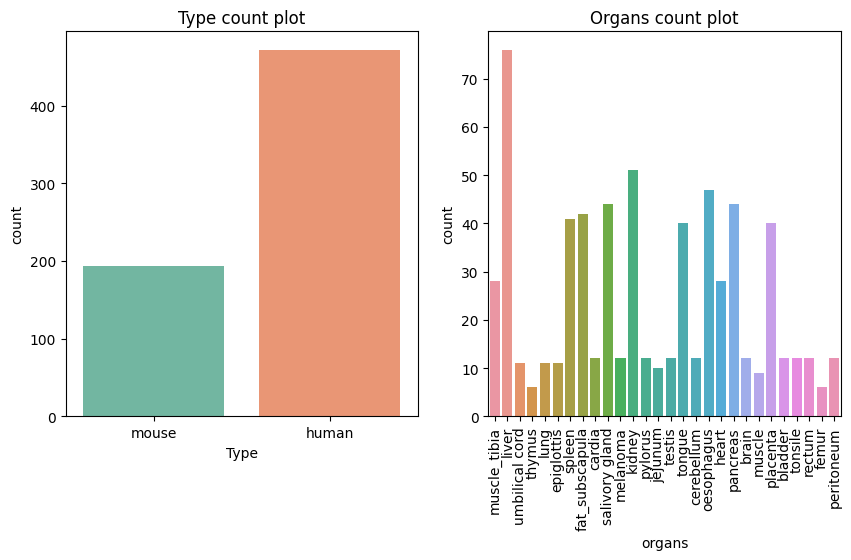

In [10]:
fig, axs = plt.subplots(1,2, figsize=(10,5))
plt.xticks(rotation=90)
axs[0].set_title('Type count plot')
axs[1].set_title('Organs count plot')

sns.countplot(df, x='Type',ax=axs[0])
sns.countplot(df, x='organs',ax=axs[1])

In [11]:
df.head()

,Type,organs,img_path,label_masks,binary_path
0,mouse,muscle_tibia,/kaggle/input/nuinsseg/mouse muscle_tibia/tiss...,/kaggle/input/nuinsseg/mouse muscle_tibia/labe...,/kaggle/input/nuinsseg/mouse muscle_tibia/mask...
1,mouse,muscle_tibia,/kaggle/input/nuinsseg/mouse muscle_tibia/tiss...,/kaggle/input/nuinsseg/mouse muscle_tibia/labe...,/kaggle/input/nuinsseg/mouse muscle_tibia/mask...
2,mouse,muscle_tibia,/kaggle/input/nuinsseg/mouse muscle_tibia/tiss...,/kaggle/input/nuinsseg/mouse muscle_tibia/labe...,/kaggle/input/nuinsseg/mouse muscle_tibia/mask...
3,mouse,muscle_tibia,/kaggle/input/nuinsseg/mouse muscle_tibia/tiss...,/kaggle/input/nuinsseg/mouse muscle_tibia/labe...,/kaggle/input/nuinsseg/mouse muscle_tibia/mask...
4,mouse,muscle_tibia,/kaggle/input/nuinsseg/mouse muscle_tibia/tiss...,/kaggle/input/nuinsseg/mouse muscle_tibia/labe...,/kaggle/input/nuinsseg/mouse muscle_tibia/mask...


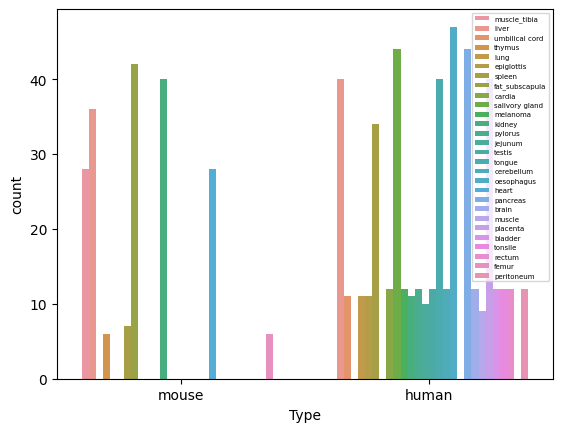

In [12]:
fig = sns.countplot(df, x='Type',hue='organs')
sns.move_legend(fig, "upper right", bbox_to_anchor=(.0, 1), title='Species')
plt.legend(fontsize='5')

* annotation의 갯수에 대해서 읽어보자
* Tiff의 이미지의 경우 읽기 위해서 skimage가 좀더 쉽게 읽을수 있다.

In [13]:
# counting cell and add dataframe
df['count'], df['width'], df['height'] = 0, 0, 0
for row in tqdm(df.itertuples(), total=len(df)): 
    mask = imread(row.label_masks)
    
    df.loc[row[0], 'width']  = mask.shape[-1]
    df.loc[row[0], 'height'] = mask.shape[-2]
    df.loc[row[0], 'count']  = mask.max()


  0%|          | 0/665 [00:00<?, ?it/s]

In [14]:
print(df['width'].unique())
print(df['height'].unique())

[512]
[512]


<Axes: xlabel='count', ylabel='organs'>

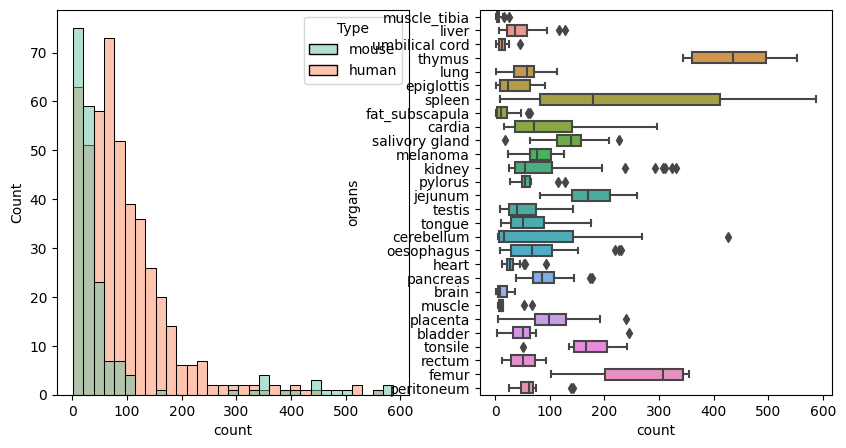

In [15]:
fig, axs = plt.subplots(1,2,figsize=(10,5))
sns.histplot(df, x='count', hue='Type', ax=axs[0])
sns.boxplot(df, x='count', y='organs', ax=axs[1])

In [16]:
## Visulization

<Figure size 640x480 with 0 Axes>

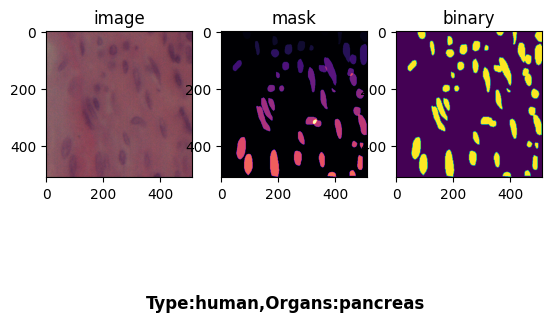

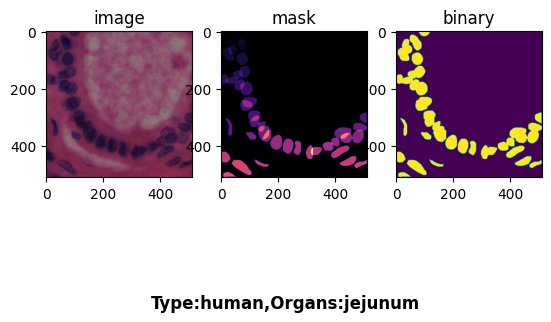

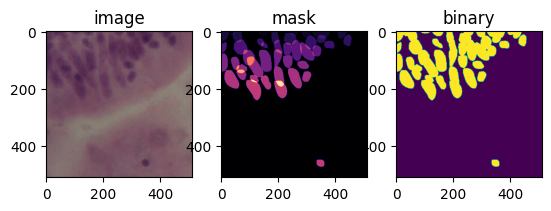

In [17]:

def show_sample(df, idx): 
    # read smaple img
    sample  = df.iloc[idx]

    plt.suptitle(f'Type:{sample.Type},Organs:{sample.organs}',fontweight ="bold", y=0.1) 

    fig, axs = plt.subplots(1,3)
    
    img     = imread(str(sample.img_path))
    lab     = imread(str(sample.label_masks))
    bi_mask = imread(str(sample.binary_path))
    
    axs[0].set_title("image")
    axs[1].set_title("mask")
    axs[2].set_title("binary")
    
    axs[0].imshow(img)
    axs[1].imshow(lab, cmap="magma")
    axs[2].imshow(bi_mask)
    
    
_=[show_sample(df, df.sample().index[0]) for i in range(3)] 

In [18]:
df['organs'].unique()

array(['muscle_tibia', 'liver', 'umbilical cord', 'thymus', 'lung',
       'epiglottis', 'spleen', 'fat_subscapula', 'cardia',
       'salivory gland', 'melanoma', 'kidney', 'pylorus', 'jejunum',
       'testis', 'tongue', 'cerebellum', 'oesophagus', 'heart',
       'pancreas', 'brain', 'muscle', 'placenta', 'bladder', 'tonsile',
       'rectum', 'femur', 'peritoneum'], dtype=object)

In [24]:
df[df.loc[:,'organs'] == i ]

,Type,organs,img_path,label_masks,binary_path,count,width,height
104,human,umbilical cord,/kaggle/input/nuinsseg/human umbilical cord/ti...,/kaggle/input/nuinsseg/human umbilical cord/la...,/kaggle/input/nuinsseg/human umbilical cord/ma...,4,512,512
105,human,umbilical cord,/kaggle/input/nuinsseg/human umbilical cord/ti...,/kaggle/input/nuinsseg/human umbilical cord/la...,/kaggle/input/nuinsseg/human umbilical cord/ma...,2,512,512
106,human,umbilical cord,/kaggle/input/nuinsseg/human umbilical cord/ti...,/kaggle/input/nuinsseg/human umbilical cord/la...,/kaggle/input/nuinsseg/human umbilical cord/ma...,2,512,512
107,human,umbilical cord,/kaggle/input/nuinsseg/human umbilical cord/ti...,/kaggle/input/nuinsseg/human umbilical cord/la...,/kaggle/input/nuinsseg/human umbilical cord/ma...,17,512,512
108,human,umbilical cord,/kaggle/input/nuinsseg/human umbilical cord/ti...,/kaggle/input/nuinsseg/human umbilical cord/la...,/kaggle/input/nuinsseg/human umbilical cord/ma...,11,512,512
109,human,umbilical cord,/kaggle/input/nuinsseg/human umbilical cord/ti...,/kaggle/input/nuinsseg/human umbilical cord/la...,/kaggle/input/nuinsseg/human umbilical cord/ma...,45,512,512
110,human,umbilical cord,/kaggle/input/nuinsseg/human umbilical cord/ti...,/kaggle/input/nuinsseg/human umbilical cord/la...,/kaggle/input/nuinsseg/human umbilical cord/ma...,15,512,512
111,human,umbilical cord,/kaggle/input/nuinsseg/human umbilical cord/ti...,/kaggle/input/nuinsseg/human umbilical cord/la...,/kaggle/input/nuinsseg/human umbilical cord/ma...,12,512,512
112,human,umbilical cord,/kaggle/input/nuinsseg/human umbilical cord/ti...,/kaggle/input/nuinsseg/human umbilical cord/la...,/kaggle/input/nuinsseg/human umbilical cord/ma...,21,512,512
113,human,umbilical cord,/kaggle/input/nuinsseg/human umbilical cord/ti...,/kaggle/input/nuinsseg/human umbilical cord/la...,/kaggle/input/nuinsseg/human umbilical cord/ma...,25,512,512


<Figure size 640x480 with 0 Axes>

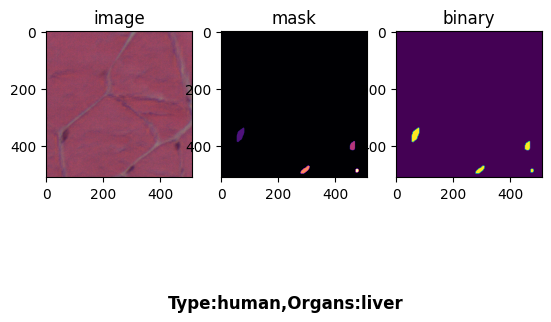

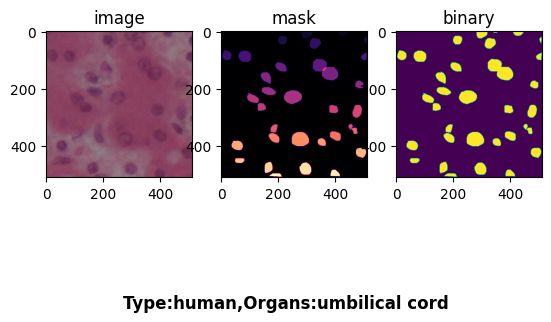

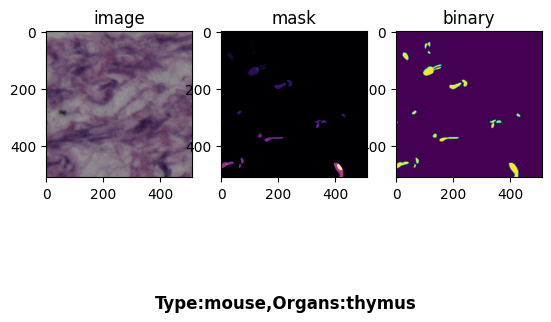

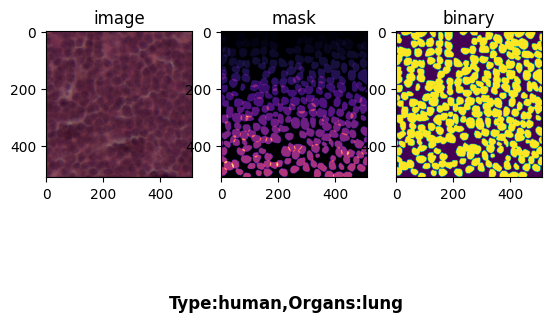

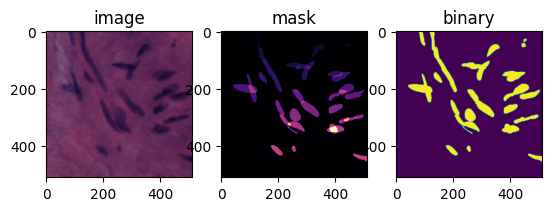

In [25]:
plot_type = ['muscle_tibia', 'liver', 'umbilical cord', 'thymus', 'lung']
for i in plot_type:
    tmp_df = df[df.loc[:,'organs'] == i].reset_index(drop=True)
    show_sample(tmp_df, tmp_df.sample().index[0])

* 이번 시간에서는 Human 에 대한 detection에 따른 Detection의 분류에 대해서 배워보도록 하겠습니다. 

In [26]:
## instance mask to bounding box

In [27]:
import numpy as np
def get_contour_bbox(msk):
    """ Reference : https://www.kaggle.com/code/dschettler8845/train-sartorius-segmentation-eda-effdet-tf """
    """ Function to return the bounding box (tl, br) for a given mask """
    
    # Get contour(s) --> There should be only one
    assert msk.dtype == np.uint8 , "image type must uint8"
    
    cnts = cv2.findContours(msk.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    contour, hierarchy = cnts
    
    if len(contour)==0:
        return None
    else:
        contour = contour[0]
    
    # Get extreme coordinates
    tl = (tuple(contour[contour[:, :, 0].argmin()][0])[0], 
          tuple(contour[contour[:, :, 1].argmin()][0])[1])
    br = (tuple(contour[contour[:, :, 0].argmax()][0])[0], 
          tuple(contour[contour[:, :, 1].argmax()][0])[1])
    
    return tl, br

In [28]:
## image crop single cell image

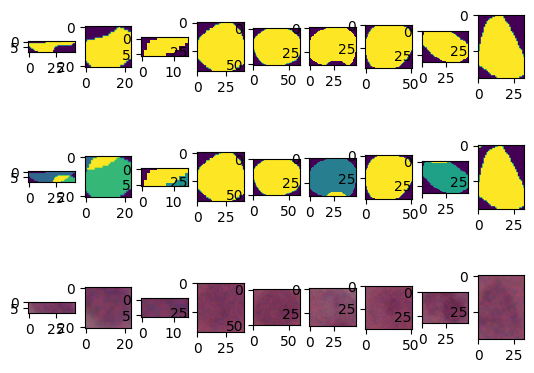

In [29]:
# Let do make bounging box

sample = df.iloc[100] 
mask = imread(sample.label_masks)
image = imread(sample.img_path)

plot_num = np.unique(mask)[:10] if len(np.unique(mask)) > 10 else np.unique(mask)

fig, axs = plt.subplots(3, len(plot_num)-1)
for i in plot_num:
    binary_img =np.where(mask==i, 1, 0).astype(np.uint8)
    min_coord, max_coord = get_contour_bbox(binary_img)
    xmin, ymin = min_coord
    xmax, ymax = max_coord
    
    axs[0, i-1].imshow(binary_img[ymin:ymax, xmin:xmax])
    axs[1, i-1].imshow(mask[ymin:ymax, xmin:xmax])
    axs[2, i-1].imshow(image[ymin:ymax, xmin:xmax])

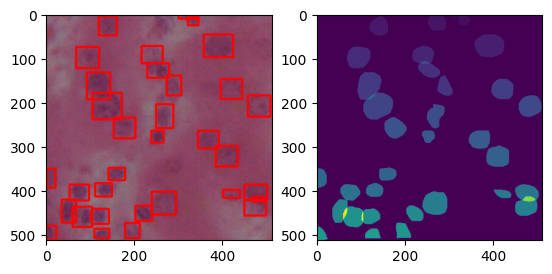

In [30]:
sample = df.iloc[100] 
mask = imread(sample.label_masks)
image = imread(sample.img_path)
fig,axs = plt.subplots(1,2)

for i in np.unique(mask)[1:]:
    binary_img =np.where(mask==i, 1, 0).astype(np.uint8)
    min_coord, max_coord = get_contour_bbox(binary_img)
    
    xmin, ymin = min_coord
    xmax, ymax = max_coord
    image = cv2.rectangle(image,(xmin,ymin),(xmax,ymax),(255,0,0),3)
    
axs[0].imshow(image)
axs[1].imshow(mask)

In [31]:
## dataset reference : https://docs.ultralytics.com/datasets/detect/#ultralytics-yolo-format
def make_cell_dataframe(df): 
    cell_list = []
    for row in tqdm(df.itertuples(), total=len(df)): 
        cell_dict = {'class'   :[], 'name'    :[], 'img_path':[],
                     'xmin'    :[], 'xmax'    :[], 'ymin'    :[], 'ymax'    :[],
                     'x_center':[], 'y_center':[], 'yolo_w'  :[], 'yolo_h'  :[]
                    }
        class_name = str(row.organs)
        mask = imread(row.label_masks)

        for i in np.unique(mask)[1:]:
            binary_img =np.where(mask==i, 1, 0).astype(np.uint8)
            min_coord, max_coord = get_contour_bbox(binary_img)

            xmin, ymin = min_coord
            xmax, ymax = max_coord
            
            cell_dict['img_path'].append(row.img_path)
            cell_dict['class'].append(class_name)
            cell_dict['name'].append(row.label_masks.with_suffix('').name)
            cell_dict['xmin'].append(xmin)
            cell_dict['xmax'].append(xmax)
            cell_dict['ymin'].append(ymin)
            cell_dict['ymax'].append(ymax)
            cell_dict['x_center'].append((xmin+xmax)/2/row.width)
            cell_dict['y_center'].append((ymin+ymax)/2/row.height)
            cell_dict['yolo_w'].append((xmax-xmin)/row.width)
            cell_dict['yolo_h'].append((ymax-ymin)/row.width)
        cell_list.append(pd.DataFrame(cell_dict))

    cell_df = pd.concat(cell_list)
    return cell_df 

In [34]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)
for foldn , (_, fold_index) in enumerate(skf.split(df,df['organs'])):
    df.loc[fold_index,'fold'] = foldn 


In [35]:
train_df = df.query(f'fold!={cfg.nfold}')
valid_df = df.query(f'fold=={cfg.nfold}')

In [36]:
train_cell_df = make_cell_dataframe(train_df)
valid_cell_df = make_cell_dataframe(valid_df)

  0%|          | 0/532 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

In [100]:
train_cell_df['class_num'] = train_cell_df['class'].apply(lambda x : class_dict[x])
valid_cell_df['class_num'] = valid_cell_df['class'].apply(lambda x : class_dict[x])

In [85]:
def prepare_yolo_dataset(df, image_path, label_path): 
    unique_name = df['name'].unique()
    for image_name in tqdm(unique_name): 
        name_df = df[df['name'] == image_name]

        label_txt = ''
        for coor_array in name_df[['class_num', 'x_center','y_center', 'yolo_w', 'yolo_h']].values: 
            coor_list = list(coor_array.reshape(-1).astype(str))
            coor_str = ' '.join(coor_list)
            # add string to label txt
            label_txt += f'{coor_str}\n'

        with open(label_path/(str(image_name)+'.txt'), 'w') as f:
            f.write(label_txt)

        shutil.copy2(name_df.iloc[0].img_path, image_path)

In [79]:
### make YOLO config

In [94]:
# Edit yaml content
yaml_content = f'''
train: /kaggle/working/datasets/train/images
val: /kaggle/working/datasets/val/images

names:
     0:  muscle_tibia,
     1:  liver,
     2:  umbilical cord,
     3:  thymus,
     4:  lung,
     5:  epiglottis,
     6:  spleen,
     7:  fat_subscapula,
     8:  cardia,
     9:  salivory gland,
     10: melanoma,
     11: kidney,
     12: pylorus,
     13: jejunum,
     14: testis,
     15: tongue,
     16: cerebellum,
     17: oesophagus,
     18: heart,
     19: pancreas,
     20: brain,
     21: muscle,
     22: placenta,
     23: bladder,
     24: tonsile,
     25: rectum,
     26: femur,
     27: peritoneum
'''

yaml_file = 'data.yaml'

with open(yaml_file, 'w') as f:
    f.write(yaml_content)

In [95]:
def mkdir_yolo_data(train_path, val_path):
    """
    make yolo data's directories
    
    parameters
    ----------
    train_path: str
        path for training data
    val_path: str
        path for validation data
    
    returns
    ----------
    train_image_path: str
        path for images of training data
    train_label_path: str
        path for labels of trainingdata
    val_image_path: str
        path for images of validation data
    val_label_path: str
        path for labels of validation data
    """
    train_image_path = Path(f'{train_path}/images')
    train_label_path = Path(f'{train_path}/labels')
    val_image_path = Path(f'{val_path}/images')
    val_label_path = Path(f'{val_path}/labels')
    
    train_image_path.mkdir(parents=True, exist_ok=True)
    train_label_path.mkdir(parents=True, exist_ok=True)
    val_image_path.mkdir(parents=True, exist_ok=True)
    val_label_path.mkdir(parents=True, exist_ok=True)
    
    return train_image_path, train_label_path, val_image_path, val_label_path

In [101]:
# make directories
train_image_path, train_label_path, \
    val_image_path, val_label_path = mkdir_yolo_data(cfg.yolo_train_path, cfg.yolo_val_path)
print(train_image_path)
print(train_label_path)
print(val_image_path)
print(val_label_path)

datasets/train/images
datasets/train/labels
datasets/val/images
datasets/val/labels


In [102]:
prepare_yolo_dataset(train_cell_df, train_image_path, train_label_path)
prepare_yolo_dataset(valid_cell_df, val_image_path, val_label_path)

  0%|          | 0/532 [00:00<?, ?it/s]

  0%|          | 0/133 [00:00<?, ?it/s]

In [86]:
from ultralytics import YOLO

# Load a model
model = YOLO('yolov8n.pt')  # load an official model

100%|██████████| 6.23M/6.23M [00:00<00:00, 20.2MB/s]


In [ ]:
model.train(data = '/kaggle/working/data.yaml',
            epochs = 100,
            imgsz = 512,
            seed = 2022,
            batch = 8,
            workers = 4)

Ultralytics YOLOv8.0.229 🚀 Python-3.10.12 torch-2.0.0+cpu CPU (Intel Xeon 2.20GHz)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/kaggle/working/data.yaml, epochs=100, time=None, patience=50, batch=8, imgsz=512, save=True, save_period=-1, cache=False, device=None, workers=4, project=None, name=train22, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=2022, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_wid

wandb: Currently logged in as: stickypanda03. Use `wandb login --relogin` to force relogin


Freezing layer 'model.22.dfl.conv.weight'


train: Scanning /kaggle/working/datasets/train/labels.cache... 532 images, 0 backgrounds, 0 corrupt: 100%|██████████| 532/532 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /kaggle/working/datasets/val/labels.cache... 133 images, 0 backgrounds, 0 corrupt: 100%|██████████| 133/133 [00:00<?, ?it/s]


Plotting labels to runs/detect/train22/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000313, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.746      2.368      1.133        133        512: 100%|██████████| 67/67 [02:56<00:00,  2.63s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:11<00:13,  2.75s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:17<00:15,  3.77s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:27<00:03,  3.61s/it]

WARNING ⚠️ NMS time limit 0.750s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:29<00:00,  3.30s/it]

                   all        133       6680      0.433      0.173      0.185        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.742      2.372      1.133         95        512: 100%|██████████| 67/67 [02:49<00:00,  2.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:11<00:12,  2.50s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:17<00:14,  3.75s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:29<00:00,  3.29s/it]

                   all        133       6680      0.548      0.167      0.202      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.751      2.387      1.136        140        512: 100%|██████████| 67/67 [02:51<00:00,  2.56s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:12<00:14,  2.94s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:19<00:16,  4.14s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:31<00:04,  4.01s/it]

WARNING ⚠️ NMS time limit 0.750s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:33<00:00,  3.68s/it]

                   all        133       6680      0.347      0.211      0.182        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.752      2.363      1.136        202        512: 100%|██████████| 67/67 [02:53<00:00,  2.59s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:03<00:31,  3.91s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:12<00:15,  3.02s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:18<00:16,  4.06s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:29<00:03,  3.70s/it]

WARNING ⚠️ NMS time limit 0.750s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:31<00:00,  3.50s/it]

                   all        133       6680      0.377      0.224      0.188        0.1



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G       1.73      2.321      1.136        185        512: 100%|██████████| 67/67 [02:53<00:00,  2.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:04<00:34,  4.36s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:12<00:14,  2.85s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:18<00:15,  3.94s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:26<00:08,  4.02s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:30<00:03,  3.92s/it]

WARNING ⚠️ NMS time limit 0.750s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:32<00:00,  3.67s/it]

                   all        133       6680      0.421        0.2      0.185     0.0998



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.717      2.252      1.142        221        512: 100%|██████████| 67/67 [02:49<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:04<00:34,  4.27s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:12<00:13,  2.80s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:18<00:16,  4.05s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:32<00:00,  3.61s/it]

                   all        133       6680      0.375      0.205      0.196       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.727      2.244      1.123         98        512: 100%|██████████| 67/67 [02:46<00:00,  2.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:11<00:12,  2.52s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:17<00:15,  3.95s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:29<00:00,  3.25s/it]

                   all        133       6680      0.364       0.22      0.206      0.111



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.707      2.199       1.13        109        512: 100%|██████████| 67/67 [02:45<00:00,  2.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:04<00:35,  4.44s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:13<00:15,  3.06s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:19<00:16,  4.08s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  78%|███████▊  | 7/9 [00:27<00:08,  4.01s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:32<00:00,  3.63s/it]

                   all        133       6680      0.364      0.231      0.217      0.117



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G      1.702      2.112       1.13        157        512: 100%|██████████| 67/67 [02:49<00:00,  2.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:04<00:33,  4.15s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:12<00:13,  2.75s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:17<00:15,  3.82s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:30<00:00,  3.44s/it]

                   all        133       6680        0.4      0.216      0.218      0.115



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.685      2.105      1.128        198        512: 100%|██████████| 67/67 [02:47<00:00,  2.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:04<00:34,  4.32s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:12<00:14,  2.82s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:18<00:16,  4.07s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:31<00:00,  3.54s/it]

                   all        133       6680      0.358      0.219        0.2      0.112



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.699       2.09      1.141        107        512: 100%|██████████| 67/67 [02:45<00:00,  2.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:03<00:31,  3.96s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:11<00:13,  2.61s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:17<00:15,  3.83s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:30<00:00,  3.35s/it]

                   all        133       6680      0.381      0.243      0.243      0.135



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G      1.684      2.071      1.142        107        512: 100%|██████████| 67/67 [02:43<00:00,  2.43s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:04<00:32,  4.07s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:12<00:13,  2.73s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:18<00:16,  4.11s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:31<00:00,  3.53s/it]

                   all        133       6680      0.426      0.244      0.237      0.131



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.676      1.974       1.13        178        512: 100%|██████████| 67/67 [02:46<00:00,  2.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:03<00:31,  3.89s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:12<00:13,  2.78s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:18<00:16,  4.01s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:31<00:00,  3.50s/it]

                   all        133       6680      0.418      0.254      0.252      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.677      1.926      1.118        300        512: 100%|██████████| 67/67 [02:48<00:00,  2.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:04<00:33,  4.18s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:11<00:13,  2.67s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:17<00:15,  3.87s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:29<00:03,  3.76s/it]

WARNING ⚠️ NMS time limit 0.750s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:31<00:00,  3.51s/it]

                   all        133       6680      0.413      0.249      0.253      0.137



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.658      1.938      1.119        111        512: 100%|██████████| 67/67 [02:46<00:00,  2.49s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):   0%|          | 0/9 [00:00<?, ?it/s]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  11%|█         | 1/9 [00:03<00:31,  3.97s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  44%|████▍     | 4/9 [00:11<00:13,  2.61s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  56%|█████▌    | 5/9 [00:17<00:14,  3.71s/it]

WARNING ⚠️ NMS time limit 1.300s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95):  89%|████████▉ | 8/9 [00:28<00:03,  3.69s/it]

WARNING ⚠️ NMS time limit 0.750s exceeded


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:30<00:00,  3.44s/it]

                   all        133       6680      0.392      0.248      0.225      0.123



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.681      1.864      1.126        207        512:  88%|████████▊ | 59/67 [02:28<00:18,  2.32s/it]